In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('realty.csv', index_col=['date'])
prices.head(10)

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
03-01-2018  258.299988     710.750000     479.600006     618.250000   
04-01-2018  257.500000     714.750000     487.450012     580.599976   
05-01-2018  259.950012     725.250000     489.700012     575.099976   
08-01-2018  260.250000     736.950012     493.450012     585.650024   
09-01-2018  269.850006     791.549988     506.700012     602.549988   
10-01-2018  269.350006     826.349976     528.000000     589.500000   
11-01-2018  270.500000     844.599976     555.250000     606.650024   
12-01-2018  268.549988     834.750000     532.700012     595.250000   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
03-01-2018   321.000000  205.300003    216.000000  603.250000  414.450012  
04-01-2018   338.600006  205.100006    219.250000  610.000000  415.600006  
05-01-2018   335.049988  205.500000    221.250000  605.549988  413.149994  
08-01-2018   332.399994  209.000000    229.250000  599.799988  413.399994  
09-01-2018   333.750000  208.533341    235.850006  606.000000  409.750000  
10-01-2018   334.049988  208.100006    247.100006  604.400024  409.899994  
11-01-2018   345.000000  210.199997    255.649994  605.349976  406.549988  
12-01-2018   337.950012  210.266663    253.600006  592.400024  404.700012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
30-12-2020  235.949997    1393.750000     567.950012     763.049988   
31-12-2020  232.850006    1432.150024     583.400024     774.549988   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
30-12-2020   264.899994  246.100006     79.300003  382.500000  356.049988  
31-12-2020   266.100006  249.100006     82.199997  414.649994  347.950012

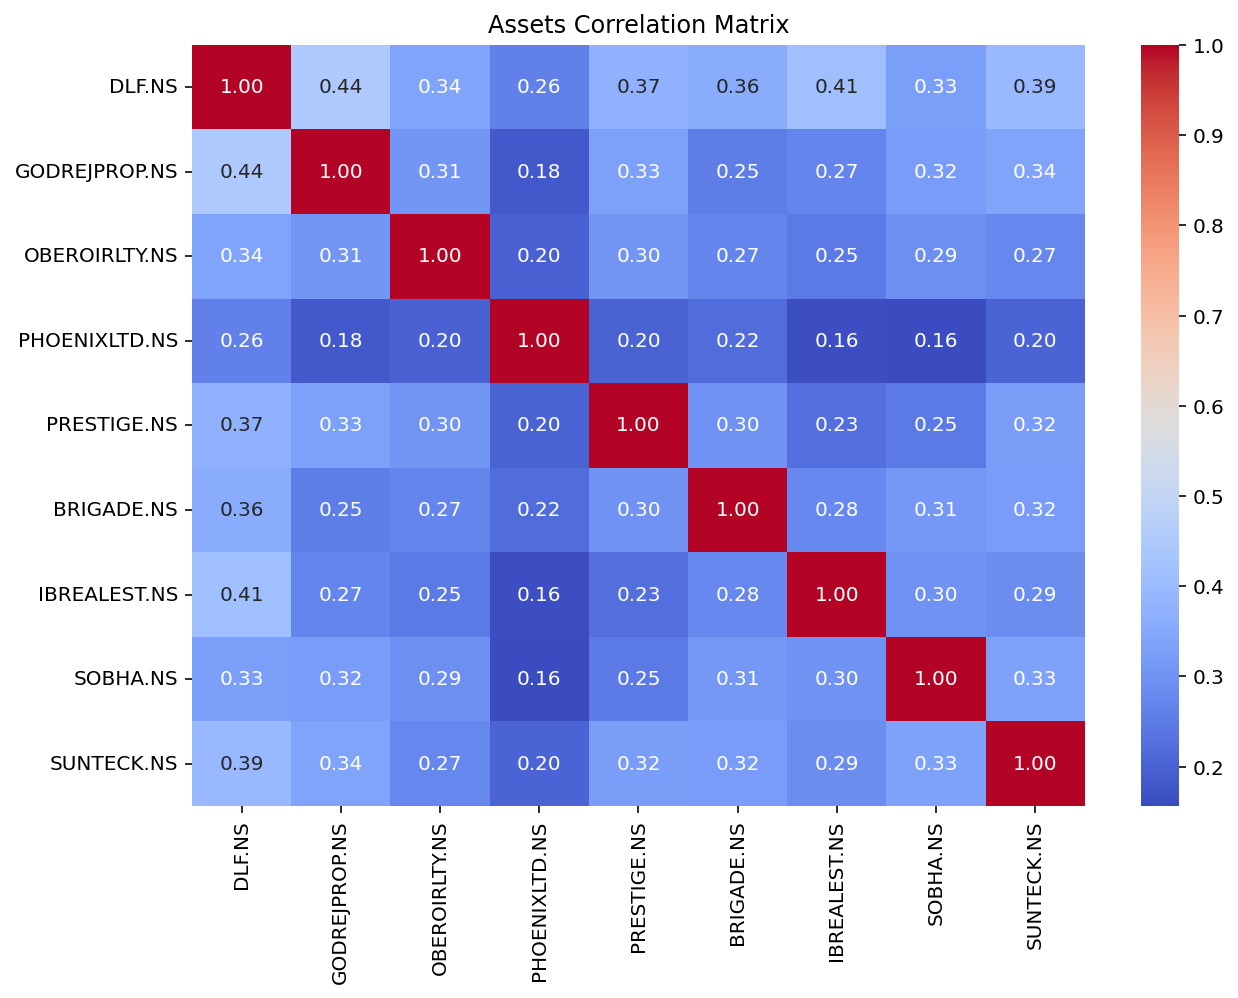

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DLF.NS', 'OBEROIRLTY.NS'), ('OBEROIRLTY.NS', 'PRESTIGE.NS'), ('OBEROIRLTY.NS', 'SOBHA.NS'), ('OBEROIRLTY.NS', 'SUNTECK.NS'), ('PHOENIXLTD.NS', 'PRESTIGE.NS'), ('PHOENIXLTD.NS', 'BRIGADE.NS')]


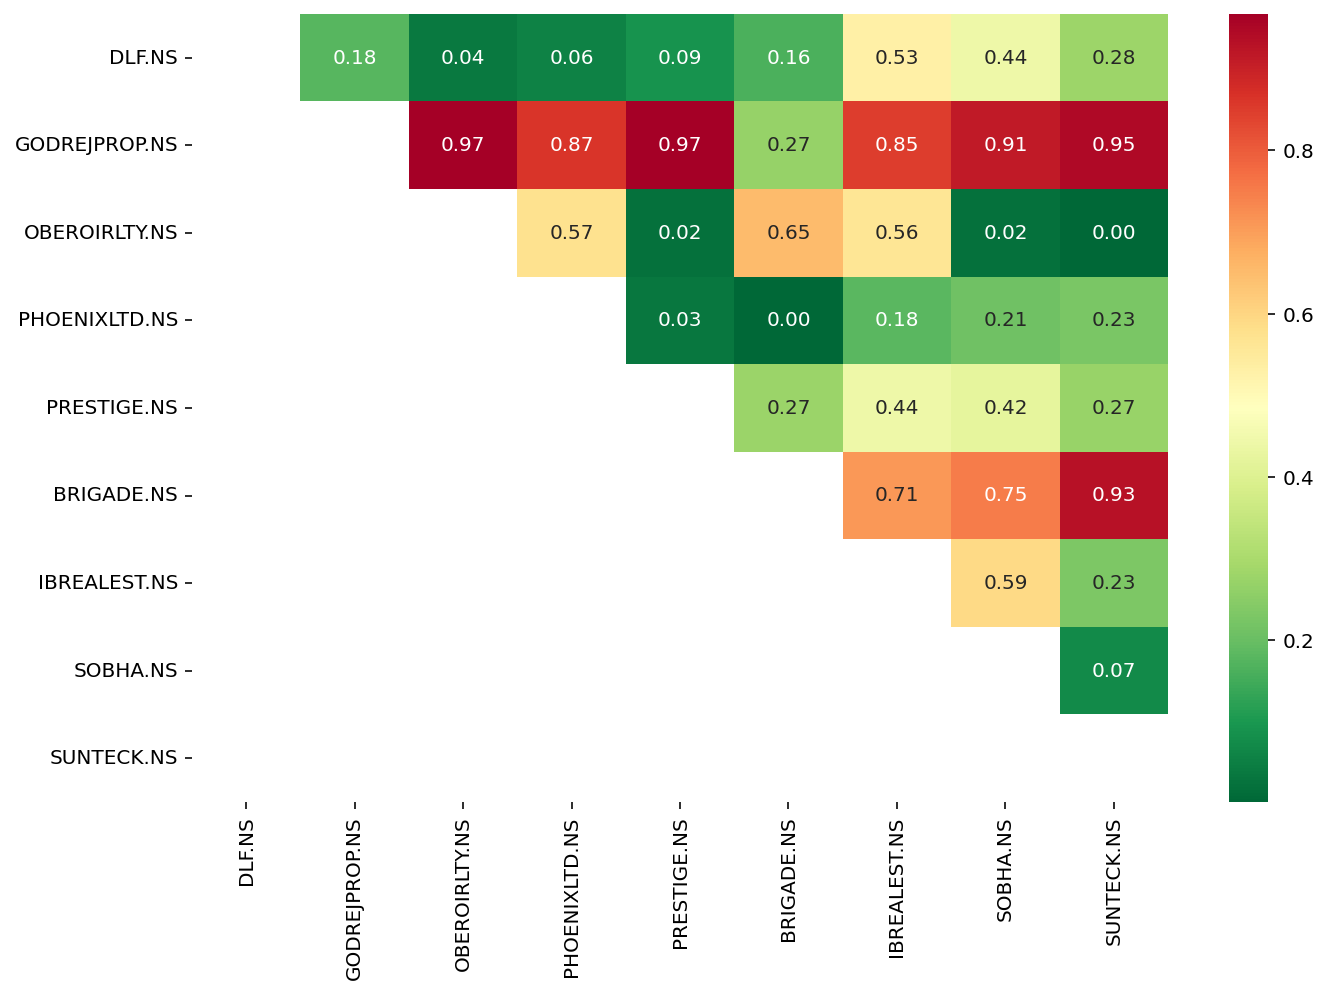

In [8]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
#ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [9]:
# final pair to test strategy
asset1 = 'OBEROIRLTY.NS'
asset2 = 'PRESTIGE.NS'

In [10]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

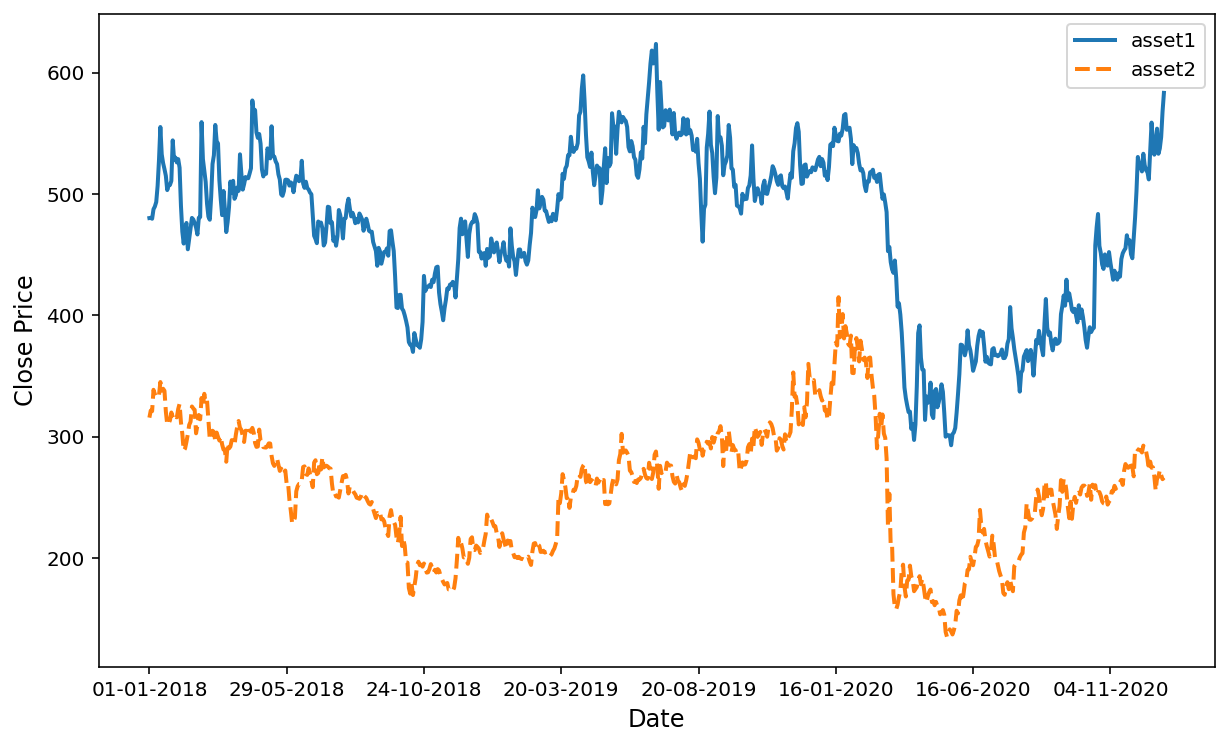

In [12]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500) 

In [13]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          3.981e+04
Date:                Thu, 12 May 2022   Prob (F-statistic):                        0.00
Time:                        16:13:40   Log-Likelihood:                         -3691.1
No. Observations:                 740   AIC:                                      7384.
Df Residuals:                     739   BIC:                                      7389.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.5457      0.003    199.518      0.000       0.540       0.551
==============================================================================
Omnibus:                       20.551   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.777
Skew:                           0.336   Prob(JB):                     8.37e-05
Kurtosis:                       2.603   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

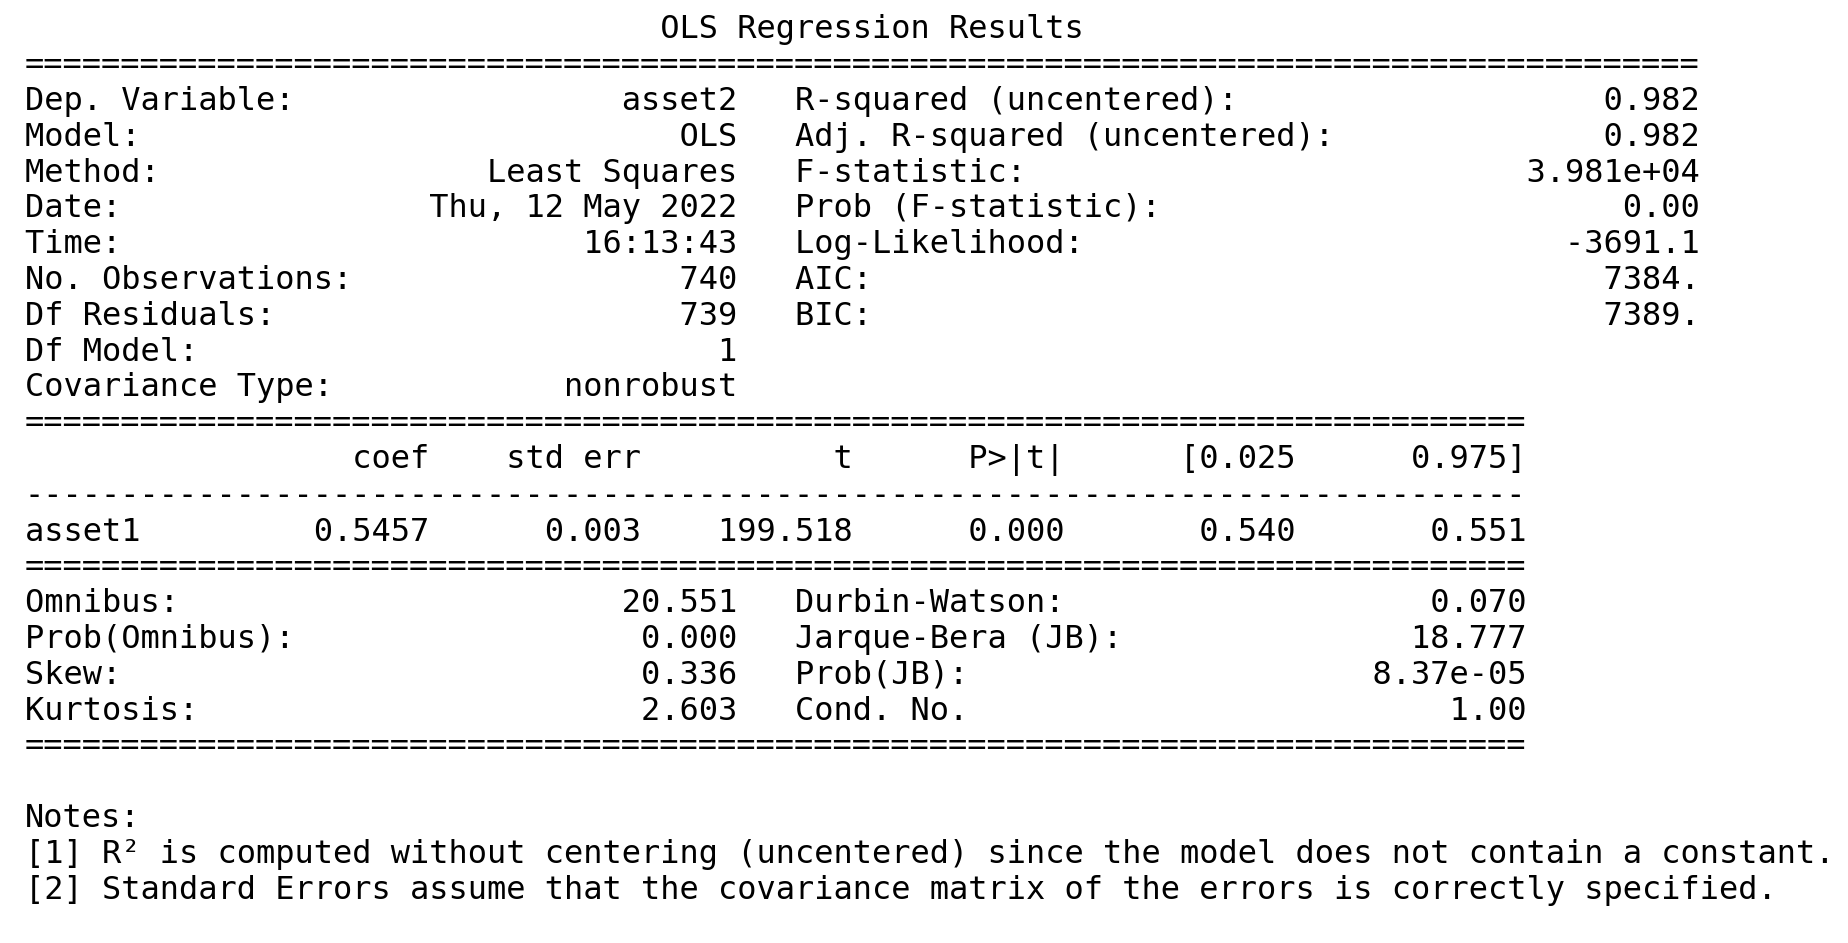

In [15]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [16]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.5457388250118352


In [19]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

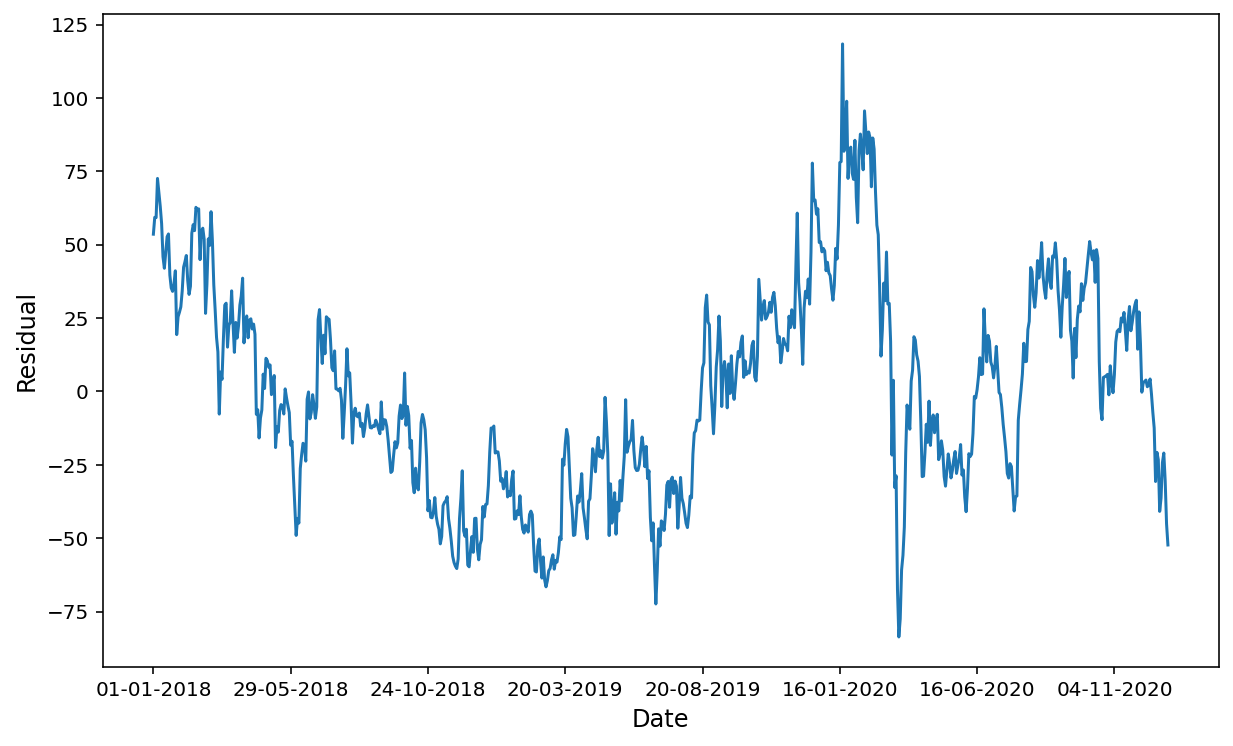

In [21]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [22]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.44998884214159,
 0.009368309673939009,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 5390.3227622949025)

In [23]:
print('Critical Value = ', adf[0])

Critical Value =  -3.44998884214159


In [24]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [25]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [26]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [27]:
signals.head()

asset1      asset2
date                              
01-01-2021  590.099976  266.799988
04-01-2021  590.099976  272.950012
05-01-2021  587.250000  275.299988
06-01-2021  587.549988  280.899994
07-01-2021  589.700012  282.600006

In [28]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [29]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  590.099976  266.799988  1.524524            1.0           -1.0
04-01-2021  590.099976  272.950012  1.164612            1.0           -1.0
05-01-2021  587.250000  275.299988  0.956568            1.0           -1.0
06-01-2021  587.549988  280.899994  0.657156            1.0           -1.0
07-01-2021  589.700012  282.600006  0.621228            1.0           -1.0

In [30]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [31]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

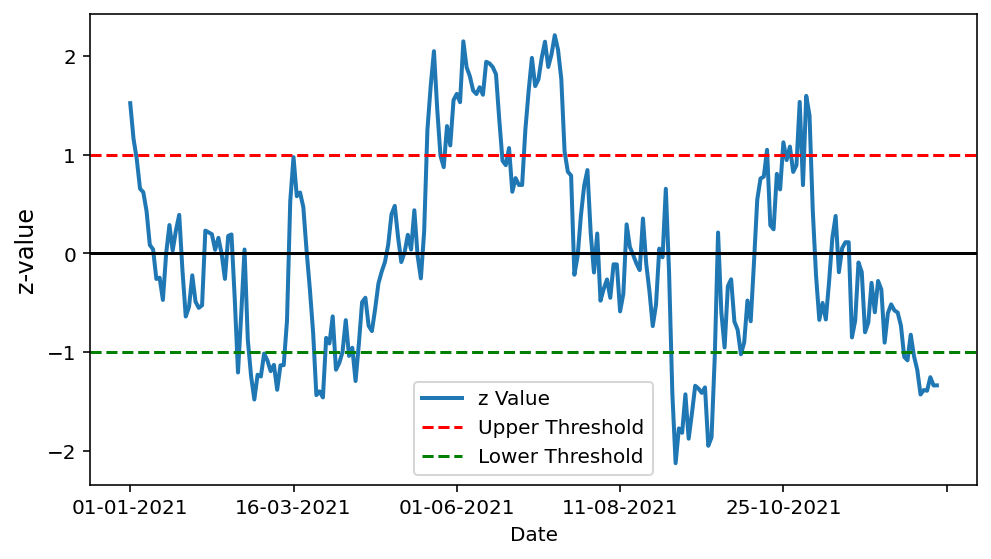

In [33]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(7, 4), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [34]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  590.099976  266.799988  1.524524            1.0           -1.0   
04-01-2021  590.099976  272.950012  1.164612            1.0           -1.0   
05-01-2021  587.250000  275.299988  0.956568            1.0           -1.0   
29-12-2021  866.250000  474.200012 -1.256038            1.0           -1.0   
30-12-2021  846.650024  466.450012 -1.340306            1.0           -1.0   
31-12-2021  861.799988  474.750000 -1.339017            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [35]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  590.099976  266.799988  1.524524            1.0           -1.0   
04-01-2021  590.099976  272.950012  1.164612            1.0           -1.0   
18-02-2021  571.549988  311.750000 -1.208378            1.0           -1.0   
24-02-2021  561.049988  306.850006 -1.244072            1.0           -1.0   
25-02-2021  553.250000  308.149994 -1.482587            1.0           -1.0   
26-02-2021  545.599976  298.100006 -1.230780            1.0           -1.0   
01-03-2021  554.450012  303.350006 -1.248845            1.0           -1.0   
02-03-2021  563.299988  302.850006 -1.016006            1.0           -1.0   
03-03-2021  557.400024  301.250000 -1.086104            1.0           -1.0   
04-03-2021  549.750000  299.549988 -1.194707            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
18-02-2021         1         1.0        -1        -1.0  
24-02-2021         1         1.0        -1        -1.0  
25-02-2021         1         0.0        -1         0.0  
26-02-2021         1         0.0        -1         0.0  
01-03-2021         1         0.0        -1         0.0  
02-03-2021         1         0.0        -1         0.0  
03-03-2021         1         0.0        -1         0.0  
04-03-2021         1         0.0        -1         0.0

In [36]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   590.099976  266.799988  1.524524            1.0           -1.0   
05-01-2021   587.250000  275.299988  0.956568            1.0           -1.0   
18-02-2021   571.549988  311.750000 -1.208378            1.0           -1.0   
19-02-2021   570.200012  297.549988 -0.609258            1.0           -1.0   
24-02-2021   561.049988  306.850006 -1.244072            1.0           -1.0   
03-11-2021  1035.500000  466.000000  1.599156            1.0           -1.0   
08-11-2021  1005.400024  487.850006  0.434786            1.0           -1.0   
17-12-2021   836.450012  450.850006 -1.050118            1.0           -1.0   
21-12-2021   818.450012  433.850006 -0.824730            1.0           -1.0   
22-12-2021   848.150024  456.899994 -1.042600            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
05-01-2021         0         1.0         0        -1.0  
18-02-2021         1         1.0        -1        -1.0  
19-02-2021         0        -1.0         0         1.0  
24-02-2021         1         1.0        -1        -1.0  
03-11-2021        -1        -1.0         1         1.0  
08-11-2021         0         1.0         0        -1.0  
17-12-2021         1         1.0        -1        -1.0  
21-12-2021         0        -1.0         0         1.0  
22-12-2021         1         1.0        -1        -1.0

In [37]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

587.250000     1
571.549988     1
836.450012     1
1005.400024    1
972.000000     1
891.750000     1
940.349976     1
899.250000     1
886.700012     1
762.549988     1
711.849976     1
603.650024     1
622.200012     1
569.849976     1
557.250000     1
558.650024     1
566.700012     1
551.900024     1
561.049988     1
848.150024     1
Name: asset1, dtype: int64

In [38]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  590.099976  266.799988  1.524524            1.0           -1.0   
04-01-2021  590.099976  272.950012  1.164612            1.0           -1.0   
05-01-2021  587.250000  275.299988  0.956568            1.0           -1.0   
06-01-2021  587.549988  280.899994  0.657156            1.0           -1.0   
07-01-2021  589.700012  282.600006  0.621228            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  863.750000  477.549988 -1.386394            1.0           -1.0   
28-12-2021  864.750000  478.350006 -1.393143            1.0           -1.0   
29-12-2021  866.250000  474.200012 -1.256038            1.0           -1.0   
30-12-2021  846.650024  466.450012 -1.340306            1.0           -1.0   
31-12-2021  861.799988  474.750000 -1.339017            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         1         0.0        -1         0.0  
28-12-2021         1         0.0        -1         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [39]:
signals = signals.reset_index()

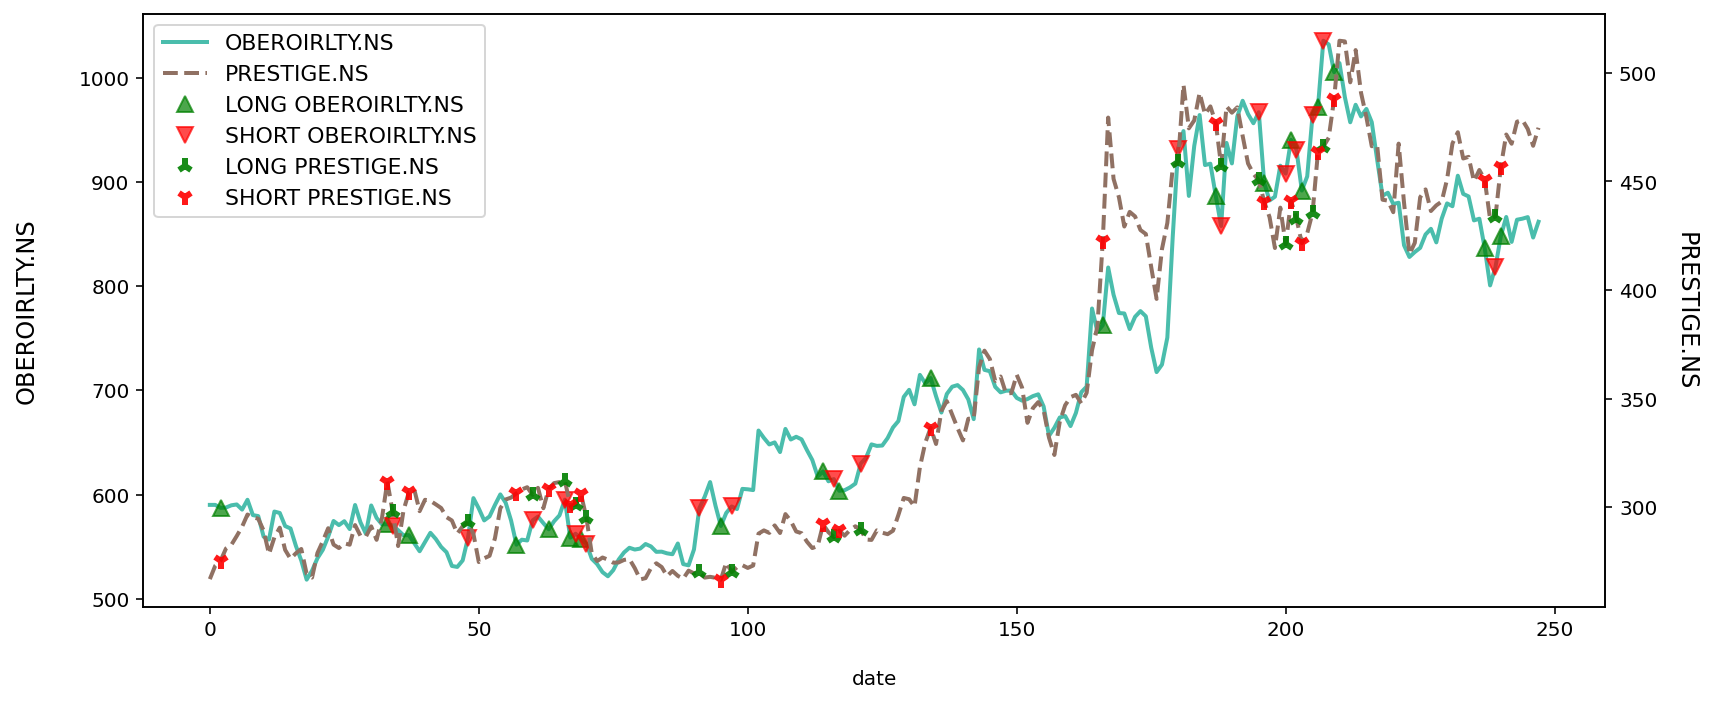

In [41]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,5))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [42]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [43]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [44]:
portfolio.head().append(portfolio.tail())

asset1      holdings1         cash1   total asset1   return1  \
0    590.099976            NaN           NaN            NaN       NaN   
1    590.099976       0.000000  100000.00000  100000.000000       NaN   
2    587.250000   56376.000000   43624.00000  100000.000000  0.000000   
3    587.549988   56404.798829   43624.00000  100028.798829  0.000288   
4    589.700012   56611.201171   43624.00000  100235.201171  0.002063   
243  863.750000  165840.000000  -20580.79879  145259.201210  0.028969   
244  864.750000  166032.000000  -20580.79879  145451.201210  0.001322   
245  866.250000  166320.000000  -20580.79879  145739.201210  0.001980   
246  846.650024  162556.804685  -20580.79879  141976.005894 -0.025821   
247  861.799988  165465.597658  -20580.79879  144884.798867  0.020488   

     positions1  
0           NaN  
1           0.0  
2           1.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [45]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1         cash1   total asset1   return1  \
0   590.099976            NaN           NaN            NaN       NaN   
2   587.250000   56376.000000  43624.000000  100000.000000  0.000000   
33  571.549988  109737.597658 -11244.798829   98492.798829  0.000146   
34  570.200012   54739.201171  43494.402342   98233.603514 -0.002632   
37  561.049988  107721.597658 -10366.396486   97355.201171  0.000148   

    positions1  
0          NaN  
2          1.0  
33         1.0  
34        -1.0  
37         1.0

In [46]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [47]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1         cash1   total asset1   return1  \
0    590.099976            NaN           NaN            NaN       NaN   
1    590.099976       0.000000  100000.00000  100000.000000       NaN   
2    587.250000   56376.000000   43624.00000  100000.000000  0.000000   
3    587.549988   56404.798829   43624.00000  100028.798829  0.000288   
4    589.700012   56611.201171   43624.00000  100235.201171  0.002063   
243  863.750000  165840.000000  -20580.79879  145259.201210  0.028969   
244  864.750000  166032.000000  -20580.79879  145451.201210  0.001322   
245  866.250000  166320.000000  -20580.79879  145739.201210  0.001980   
246  846.650024  162556.804685  -20580.79879  141976.005894 -0.025821   
247  861.799988  165465.597658  -20580.79879  144884.798867  0.020488   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  266.799988            NaN            NaN            NaN   
1           0.0  272.950012       0.000000  100000.000000  100000.000000   
2           1.0  275.299988  -53408.197633  153408.197633  100000.000000   
3           0.0  280.899994  -54494.598817  153408.197633   98913.598817   
4           0.0  282.600006  -54824.401183  153408.197633   98583.796450   
243         0.0  477.549988 -185289.395266  271806.418934   86517.023668   
244         0.0  478.350006 -185599.802367  271806.418934   86206.616568   
245         0.0  474.200012 -183989.604734  271806.418934   87816.814201   
246         0.0  466.450012 -180982.604734  271806.418934   90823.814201   
247         0.0  474.750000 -184203.000000  271806.418934   87603.418934   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000        -1.0  
3   -0.010864         0.0  
4   -0.003334         0.0  
243 -0.043538         0.0  
244 -0.003588         0.0  
245  0.018678         0.0  
246  0.034242         0.0  
247 -0.035458         0.0

In [48]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1         cash1   total asset1   return1  \
0   590.099976            NaN           NaN            NaN       NaN   
2   587.250000   56376.000000  43624.000000  100000.000000  0.000000   
33  571.549988  109737.597658 -11244.798829   98492.798829  0.000146   
34  570.200012   54739.201171  43494.402342   98233.603514 -0.002632   
37  561.049988  107721.597658 -10366.396486   97355.201171  0.000148   

    positions1      asset2      holdings2          cash2   total asset2  \
0          NaN  266.799988            NaN            NaN            NaN   
2          1.0  275.299988  -53408.197633  153408.197633  100000.000000   
33         1.0  311.750000 -120959.000000  213887.697633   92928.697633   
34        -1.0  297.549988  -57724.697633  156163.000000   98438.302367   
37         1.0  306.850006 -119057.802367  215691.901183   96634.098817   

     return2  positions2  
0        NaN         NaN  
2   0.000000        -1.0  
33 -0.033884        -1.0  
34  0.059289         1.0  
37 -0.016681        -1.0

In [49]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

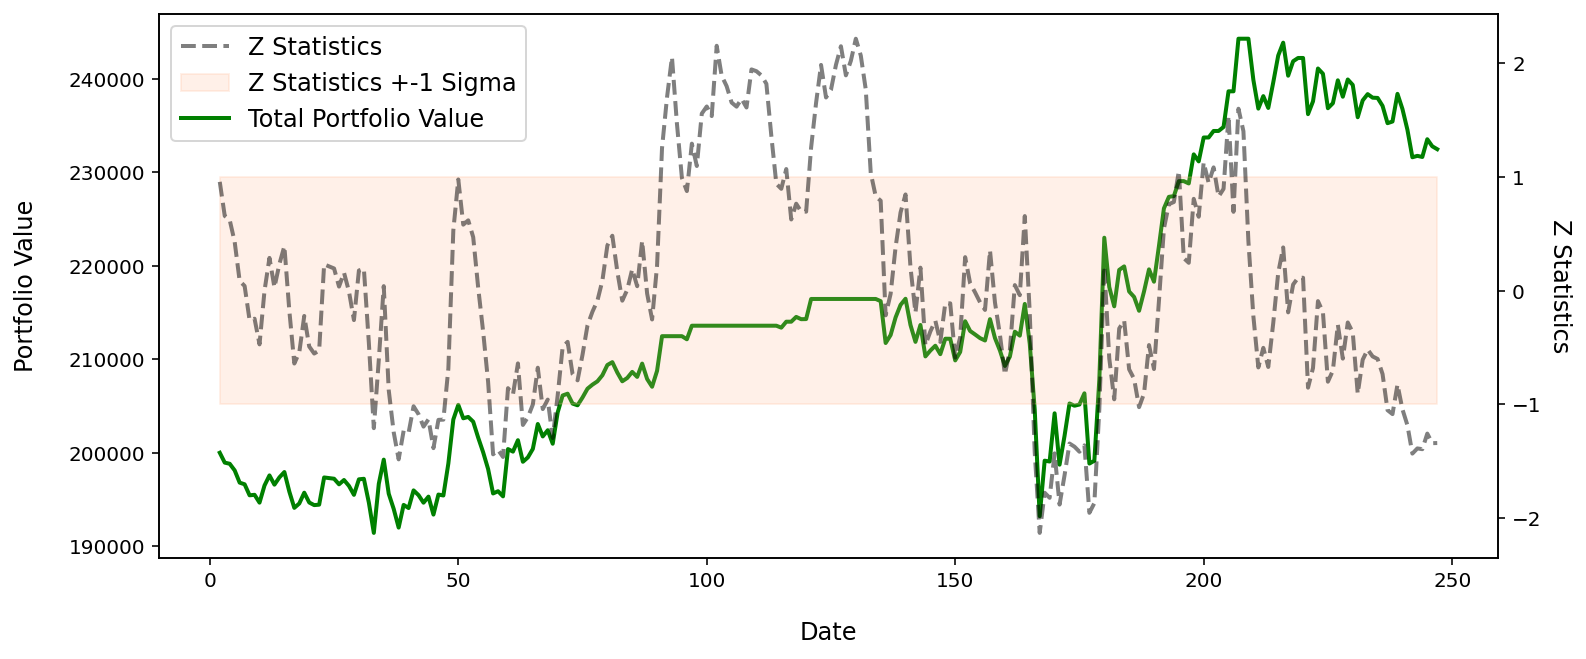

In [51]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,5),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left', fontsize=12);
plt.savefig('chart8', dpi=500);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

232488.2178016

In [46]:
profit = final_portfolio - 2*initial_capital
profit

32488.217801599996

In [47]:
roi = (profit/(2*initial_capital))*100
roi

16.244108900799997

In [48]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [49]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 251.449%
